In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from string import Template
from typing import List

from blm_activity_db import BlmActivityDb, Community
from tweet_mgr import Stance
from tweet_sentiment import PronounCounts


In [2]:
db = BlmActivityDb()
col_names = ["Stance", "NumTweets", "FirstSingularUsage", "FirstPluralUsage", "SecondUsage", "ThirdUsage"]
pronoun_columns = ", a.".join(col_names)
query = \
f"SELECT {pronoun_columns} "\
"FROM Community c JOIN AccountActivity a "\
"ON c.PeriodId = a.PeriodId and c.CommunityId = a.CommunityId "\
"WHERE c.PeriodId = ? and c.Stance in (-1, 1) "

def get_pronoun_counts(period: int):
    activist_pc, counter_pc = PronounCounts(), PronounCounts()
    activist_tweets, counter_tweets = 0, 0
    with db.conn:
        cur = db.conn.cursor()
        cur.execute(query, (period,))
        row = cur.fetchone()
        while row:
            num_tweets = row[1]
            if row[0] == Stance.Protest:
                activist_tweets += num_tweets
                activist_pc.first_singular += num_tweets * row[2]
                activist_pc.first_plural += num_tweets * row[3]
                activist_pc.second += num_tweets * row[4]
                activist_pc.third += num_tweets * row[5]
            else:
                counter_tweets += num_tweets
                counter_pc.first_singular += num_tweets * row[2]
                counter_pc.first_plural += num_tweets * row[3]
                counter_pc.second += num_tweets * row[4]
                counter_pc.third += num_tweets * row[5]
            row = cur.fetchone()
    activist_pc /= activist_tweets
    counter_pc /= counter_tweets
    return activist_pc, counter_pc


In [30]:
template = Template("""
## Pronoun Usage for Period $period

| Stance | First Person Singular | First Person Plural | Second Person | Third Person |
|:------:|:-----:|:-----:|:-----:|:-----:|
| Activist | $afs | $afp | $as | $at |
| Counter-Protest | $cfs | $cfp | $cs |$ct |

""")
report = ""
for period in [i for i in range(1, 7)]:
    a_pc, c_pc = get_pronoun_counts(period)
    subs = {
        "period": period,
        "afs": round(a_pc.first_singular, 3), 
        "afp": round(a_pc.first_plural, 3), 
        "as": round(a_pc.second, 3), 
        "at": round(a_pc.third, 3),
        "cfs": round(c_pc.first_singular, 3), 
        "cfp": round(c_pc.first_plural, 3), 
        "cs": round(c_pc.second, 3), 
        "ct": round(c_pc.third, 3),
    }
    report += template.safe_substitute(subs)

report_path = "../data/Reports/pronoun_counts.md"
with open(report_path, "w") as f:
    f.write(report)

In [3]:
activist_pcs = []
counter_pcs = []
for period in [i for i in range(1, 7)]:
    a_pc, c_pc = get_pronoun_counts(period)
    activist_pcs.append(a_pc)
    counter_pcs.append(c_pc)


In [13]:
activist_2014_pronouns = {"1s":[], "1p":[], "2d": [], "3d": []}
counter_2014_pronouns = {"1s":[], "1p":[], "2d": [], "3d": []}
activist_2020_pronouns = {"1s":[], "1p":[], "2d": [], "3d": []}
counter_2020_pronouns = {"1s":[], "1p":[], "2d": [], "3d": []}

def assign_pronoun_counts(pc_list: List[PronounCounts], d: dict):
    for pc in pc_list:
        d["1s"].append(pc.first_singular * 100)
        d["1p"].append(pc.first_plural * 100)
        d["2d"].append(pc.second * 100)
        d["3d"].append(pc.third * 100)

assign_pronoun_counts(activist_pcs[:3], activist_2014_pronouns)
assign_pronoun_counts(counter_pcs[:3], counter_2014_pronouns)
assign_pronoun_counts(activist_pcs[3:], activist_2020_pronouns)
assign_pronoun_counts(counter_pcs[3:], counter_2020_pronouns)


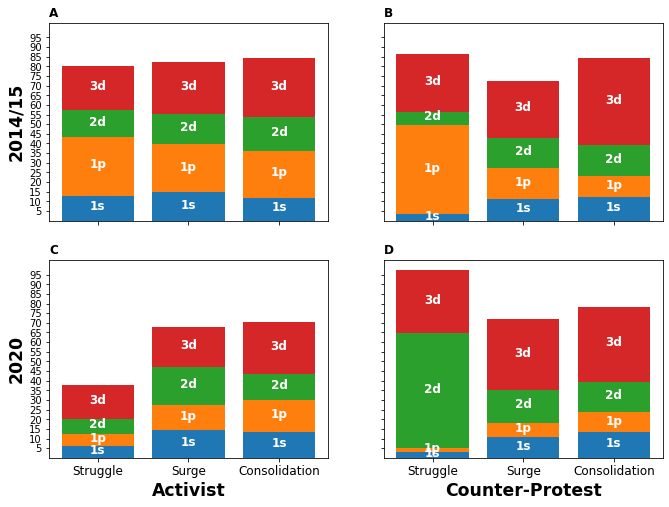

In [14]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(11,8))
width = 0.8
x = np.array([i for i in range(1, 4)])
plt.yticks([i for i in range(5, 65, 5)]) 
plt.xticks(x - width, ["Struggle", "Surge", "Consol"], fontsize="large")

def draw_chart(ax, title, pronouns, x_label="", y_label=""):
    bottoms = np.array([0.0, 0.0, 0.0])
    for pronoun in pronouns:
        ax.bar(
            x = ax.get_xticks(), 
            height=pronouns[pronoun], 
            width=width, 
            bottom=bottoms,
#            color=color_chart[emo]
        )
        for i, x in enumerate(ax.get_xticks()):
            if pronouns[pronoun][i] < 1.0:
                continue
            ax.text(
                x, 
                bottoms[i] + 0.5 * pronouns[pronoun][i] - 1.0, 
                pronoun, 
                ha="center", 
                color="w", 
                fontweight="bold",
                fontsize="large")
        bottoms += np.array(pronouns[pronoun])
    ax.set_title(title, loc="left", fontweight="bold")
    ax.set_yticks([i for i in range(5, 100, 5)])
    ax.set_xticks([0.2, 1.2, 2.2])
    ax.set_xticklabels(["Struggle", "Surge", "Consolidation"], fontsize="large")
    ax.set_xlabel(x_label, fontweight="demibold", fontsize="xx-large")
    ax.set_ylabel(y_label, fontweight="demibold", fontsize="xx-large")

axes = [ax1, ax2, ax3, ax4]
titles = ["A", "B", "C", "D"]
pronoun_maps = [activist_2014_pronouns, counter_2014_pronouns, activist_2020_pronouns, counter_2020_pronouns]
xlabels = ["", "", "Activist", "Counter-Protest"]
ylabels = ["2014/15", "", "2020", ""]
for i, (ax, title, pronouns, x_label, y_label) in enumerate(zip(axes, titles, pronoun_maps, xlabels, ylabels)):
    draw_chart(ax, title, pronouns, x_label, y_label)